In [2]:
!conda info


     active environment : neuro
    active env location : /opt/miniconda-latest/envs/neuro
            shell level : 2
       user config file : /home/neuro/.condarc
 populated config files : /opt/miniconda-latest/.condarc
          conda version : 4.8.3
    conda-build version : not installed
         python version : 3.7.6.final.0
       virtual packages : __glibc=2.24
       base environment : /opt/miniconda-latest  (writable)
           channel URLs : https://conda.anaconda.org/conda-forge/linux-64
                          https://conda.anaconda.org/conda-forge/noarch
                          https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/linux-64
                          https://repo.anaconda.com/pkgs/r/noarch
          package cache : /opt/miniconda-latest/pkgs
                          /home/neuro/.conda/pkgs
       envs directories : /opt/miniconda-l

# MRI Normalisation

To ensure brain slices align throughout the samples we can warp the MRI volumes to fit a template.

Two main approaches are using `ANTs` and `SPM12`, with the first being more accurate but being more computationally expensive than the latter.

In [2]:
import os
import time
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from nipype.interfaces.io import SelectFiles, DataSink, FreeSurferSource
from nipype.interfaces.spm import Normalize12
from nipype.algorithms.misc import Gunzip
from nipype.pipeline.engine import Workflow, Node, MapNode
from nipype.interfaces.matlab import MatlabCommand
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.freesurfer import MRIConvert
from nipype.interfaces.freesurfer import FSCommand, MRIConvert, BBRegister

# fs_dir = "/usr/local/freesurfer/"
# FSCommand.set_default_subjects_dir(fs_dir)
# MatlabCommand.set_default_paths("/usr/local/MATLAB/R2014a/toolbox/spm12")
# MatlabCommand.set_default_matlab_cmd("matlab -nodesktop -nosplash")

210403-13:37:34,65 nipype.utils WARNING:
	 A newer version (1.5.1) of nipy/nipype is available. You are using 1.5.0-rc1.post-dev


## Normalisation with `SPM-12`

Using `SPM` to normalise the data is a lot faster and simpler than the `ANTs` method. Although it may produce less accurate results, it is likely a better fit for normalising a large dataset such as ours.

First we will need to specify the working directories.

In [3]:
input_subject = "/mnt/HDD/Data/nipype_test/input/uncompressed/sub002.nii"
input_template = "/mnt/HDD/Data/nipype_test/templates/study_templates/Oasis/MICCAI2012-Multi-Atlas-Challenge-Data/T_template0.nii.gz"

#### Normalise

Create the normalisation object.

In [19]:
norm12 = Normalize12()
norm12.inputs.image_to_align = input_subject
norm12.inputs.tpm = input_template

Run the normalisation.

In [20]:
norm12.run()

#### Analyse output

Now we can look at the output.

In [28]:
norm_outputs = norm12.aggregate_outputs()
norm_outputs


deformation_field = /mnt/HDD/Data/nipype_test/input/uncompressed/y_sub002.nii
normalized_files = <undefined>
normalized_image = /mnt/HDD/Data/nipype_test/input/uncompressed/wsub002.nii

Now we can examine the output

In [130]:
def compare_normalisation(input_subject, input_template, norm_outputs):
    for title, path in [("Original", input_subject), ("Template", input_template), ("Normalised", norm_outputs.normalized_image)]:
        norm_nii = nib.load(path)
        volume = norm_nii.get_fdata()
        transverse_slice = ("transverse plane (XY)", volume[volume.shape[0] // 3, :, :]) 
        coronal_slice = ("coronal plane (YZ)", volume[:, volume.shape[1] // 2, :])
        sagital_slice = ("sagital plane (XZ)", volume[:, :, volume.shape[2] // 2])
        fig = plt.figure(figsize=(12, 4))
        plt.subplots_adjust(wspace=0.1, hspace=0.1)
        plt.title("{0} {1}".format(title, volume.shape))
        plt.xticks([])
        plt.yticks([])
        for i, (plane, img) in enumerate([transverse_slice, coronal_slice, sagital_slice]):
            ax = fig.add_subplot(1, 3, i+1)
            ax.imshow(img, cmap='gray')
            ax.set_xticks([]) 
            ax.set_yticks([])
            ax.set_xlabel(plane)
        plt.show()

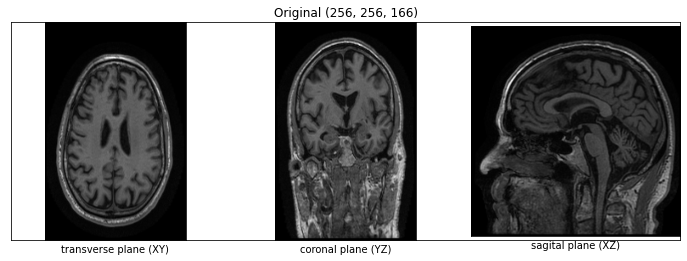

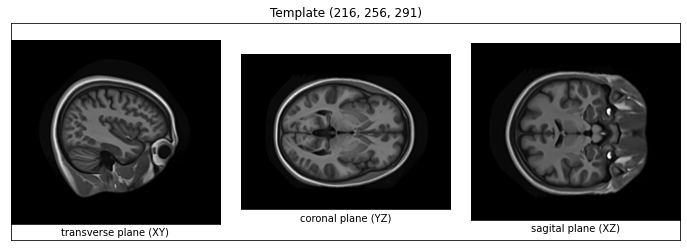

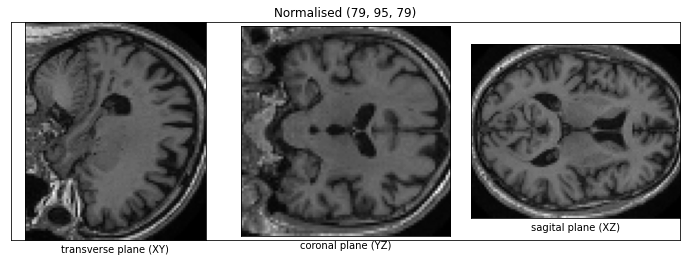

In [72]:
compare_normalisation(input_subject, input_template, norm_outputs)

## Conforming MRIs

From the outputs it is evident that the template and input MRI dimensions are not aligned. We will need to reformat the template to match the sample dimensions.

In [80]:
def compare_conversion(orig_volume, conv_volume):
    for (title, volume) in [("Original", orig_volume), ("Converted", conv_volume)]:
        transverse_slice = ("transverse plane (XY)", volume[volume.shape[0] // 3, :, :]) 
        coronal_slice = ("coronal plane (YZ)", volume[:, volume.shape[1] // 2, :])
        sagital_slice = ("sagital plane (XZ)", volume[:, :, volume.shape[2] // 2])
        fig = plt.figure(figsize=(12, 4))
        plt.subplots_adjust(wspace=0.1, hspace=0.1)
        plt.title("{0} {1}".format(title, volume.shape))
        plt.xticks([])
        plt.yticks([])
        for i, (plane, img) in enumerate([transverse_slice, coronal_slice, sagital_slice]):
            ax = fig.add_subplot(1, 3, i+1)
            ax.imshow(img, cmap='gray')
            ax.set_xticks([]) 
            ax.set_yticks([])
            ax.set_xlabel(f"Plane {i}")

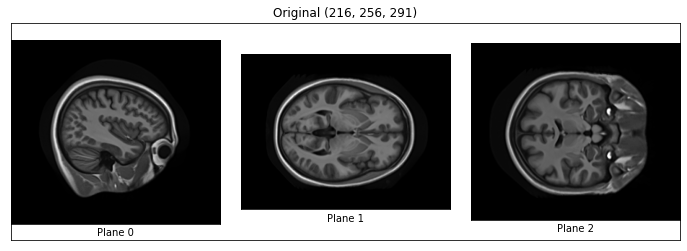

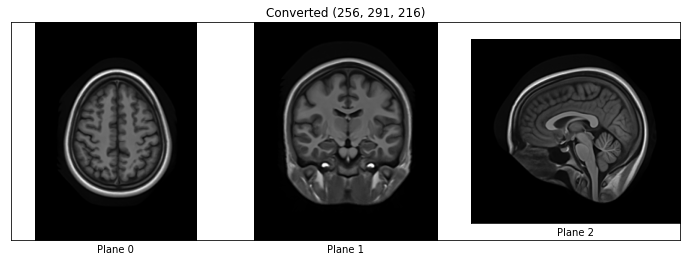

In [81]:
norm_nii = nib.load(input_template)
volume_org = norm_nii.get_fdata()

volume_alt = np.swapaxes(volume_org, 0, 1)
volume_alt = np.swapaxes(volume_alt, 1, 2)
volume_alt = np.flip(volume_alt, axis=1)

compare_conversion(volume_org, volume_alt)

The template orientation now matches the input samples, but the dimensions still need resizing.

### Conforming the template with `FreeSurfer`

This conversion is a bit combersome and the MRIs still need resizing. Lukily the above manipulation as well as the resizing can be performed with `FreeSurfer` using the `MRIConvert` module.

First we must specify the FreeSurfer source.

In [117]:
freesurfer_out_dir = "/mnt/HDD/Data/nipype_test/output/freesurfer"
converted_template = os.path.join(freesurfer_out_dir, "converted_template.nii")

Now we can specify the conversion for the template.

In [118]:
mct = MRIConvert(
    in_file = input_template,
    out_file = converted_template,
    in_type = "niigz",
    out_type = "nii",
    cw256=True,
    in_orientation = "RSA",
    out_orientation = "SAR",
    slice_reverse=True,
)

Lets convert the template.

In [119]:
mct.cmdline
mct.run()

210331-16:30:48,441 nipype.interface INFO:
	 stdout 2021-03-31T16:30:48.441631:mri_convert --cw256 --in_orientation RSA --in_type nii --out_orientation SAR --out_type nii --slice-reverse --input_volume /mnt/HDD/Data/nipype_test/templates/study_templates/Oasis/MICCAI2012-Multi-Atlas-Challenge-Data/T_template0.nii.gz --output_volume /mnt/HDD/Data/nipype_test/output/freesurfer/converted_template.nii 
210331-16:30:54,216 nipype.interface INFO:
	 stdout 2021-03-31T16:30:54.216286:reading from /mnt/HDD/Data/nipype_test/templates/study_templates/Oasis/MICCAI2012-Multi-Atlas-Challenge-Data/T_template0.nii.gz...
210331-16:30:54,217 nipype.interface INFO:
	 stdout 2021-03-31T16:30:54.216286:Reversing slices, updating vox2ras
210331-16:30:54,217 nipype.interface INFO:
	 stdout 2021-03-31T16:30:54.216286:TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
210331-16:30:54,218 nipype.interface INFO:
	 stdout 2021-03-31T16:30:54.216286:Setting input orientation to RSA
210331-16:30:54,218 nipype.interface INFO

We can now check the outputs dimensions and orientation.

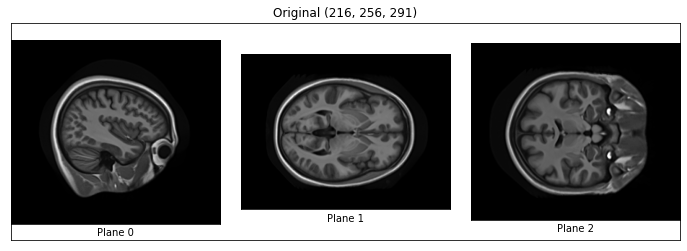

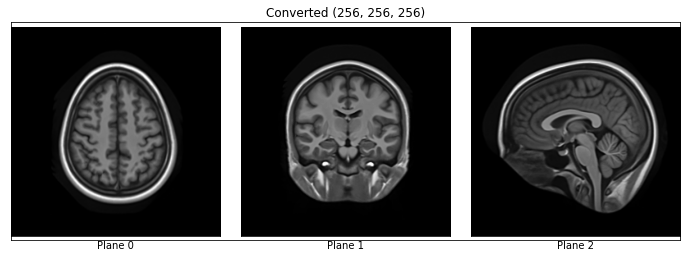

In [120]:
template_orig = nib.load(input_template)
template_conv = nib.load(converted_template)
orig_volume = template_orig.get_fdata()
conv_volume = template_conv.get_fdata()

compare_conversion(orig_volume, conv_volume)

The template now matches the orientation of the ADNI samples.

We have also conformed the MRI template to a 1x1x1 voxel format of dimensions 256x256x256. 

This will ensure accurate normalisation of the samples to the template.

### Conforming the samples

We will now apply `MRIConvert` to a sample before normalising again and analysing the result.

In [127]:
converted_subject = os.path.join(freesurfer_out_dir, "converted_subject.nii")

mcs = MRIConvert(
    in_file = input_subject,
    out_file = converted_subject,
    in_type = "nii",
    out_type = "nii",
    cw256=True,
    in_orientation = "SAR",
    out_orientation = "SAR",
    # slice_reverse=True,
)

mcs.cmdline
mcs.run()

210331-16:35:45,911 nipype.interface INFO:
	 stdout 2021-03-31T16:35:45.911251:mri_convert --cw256 --in_orientation SAR --in_type nii --out_orientation SAR --out_type nii --input_volume /mnt/HDD/Data/nipype_test/input/uncompressed/sub002.nii --output_volume /mnt/HDD/Data/nipype_test/output/freesurfer/converted_subject.nii 
210331-16:35:45,912 nipype.interface INFO:
	 stderr 2021-03-31T16:35:45.912940:INFO: using NIfTI-1 qform 
210331-16:35:50,9 nipype.interface INFO:
	 stdout 2021-03-31T16:35:50.009196:reading from /mnt/HDD/Data/nipype_test/input/uncompressed/sub002.nii...
210331-16:35:50,10 nipype.interface INFO:
	 stdout 2021-03-31T16:35:50.009196:TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
210331-16:35:50,11 nipype.interface INFO:
	 stdout 2021-03-31T16:35:50.009196:Setting input orientation to SAR
210331-16:35:50,11 nipype.interface INFO:
	 stdout 2021-03-31T16:35:50.009196:i_ras = (0, 0, 1)
210331-16:35:50,12 nipype.interface INFO:
	 stdout 2021-03-31T16:35:50.009196:j_ras = (0, 1,

Now we can compare the original and conformed volumes.

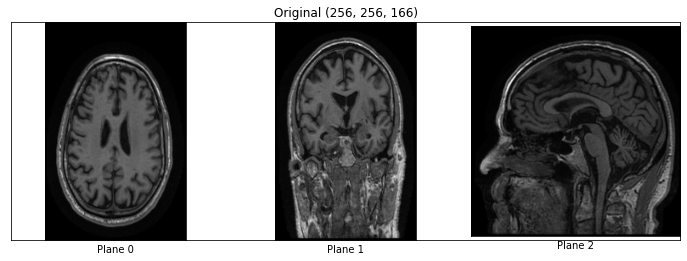

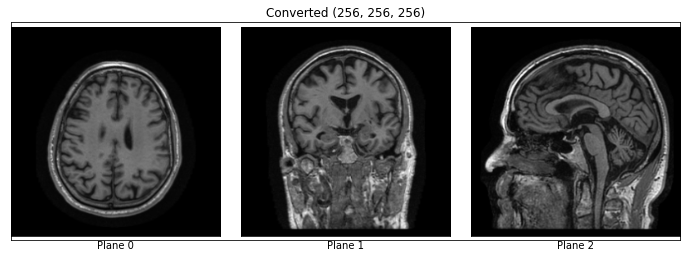

In [128]:
subject_orig = nib.load(input_subject)
subject_conv = nib.load(converted_subject)
orig_volume = subject_orig.get_fdata()
conv_volume = subject_conv.get_fdata()

compare_conversion(orig_volume, conv_volume)

## Normalisation with conformed volumes

Now the template and subject MRI volumes are conformed and oriented the same way `SPMs` normalisation should work better, lets try it again.

In [131]:
subject_to_norm = "/mnt/HDD/Data/nipype_test/output/freesurfer/converted_subject.nii"
template_for_norm = "/mnt/HDD/Data/nipype_test/output/freesurfer/converted_template.nii"

norm12 = Normalize12()
norm12.inputs.image_to_align = subject_to_norm
norm12.inputs.tpm = template_for_norm
norm12.run()

Lets look at the result.

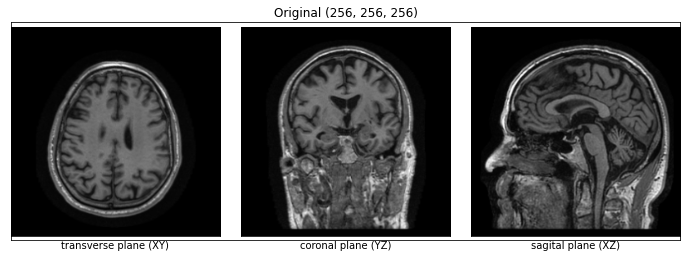

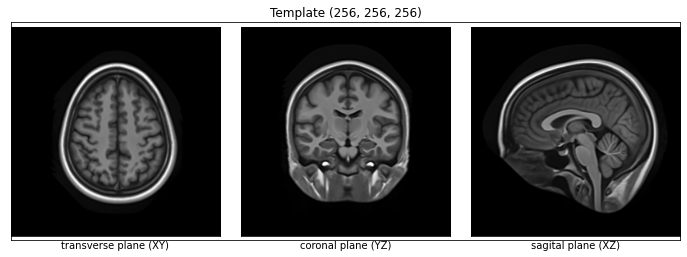

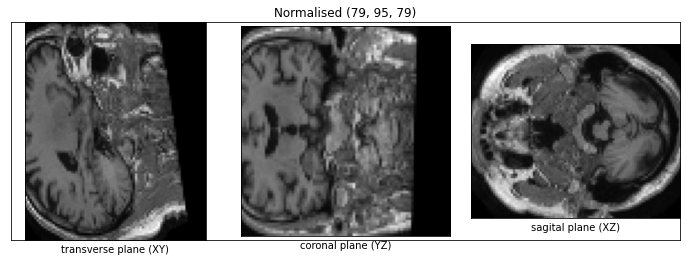

In [132]:
norm_outputs = norm12.aggregate_outputs()
compare_normalisation(subject_to_norm, template_for_norm, norm_outputs)

---

## `TODO`

- Resample template and samples as (128,128,128) and facing the correct direction:
    - Use `FreeSurfer` [MRIConvert](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.freesurfer.preprocess.html):
        - `in_file` = input MRI path
        - `in_orientation` = input orientation
        - `out_orientation` = target orientation
        - `out_i_size` = target ith dimension size
        - `out_j_size` = target jth dimension size
        - `out_k_size` = target kth dimension size
        - _check smoothing, denoising and other params_
    - Apply some other smoothing, denoising pre-processing steps if not with `MRIConvert`
- Normalise each sample with `SPM` [Normalize12](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.spm.preprocess.html)
- Extract brain fro each sample with `FSL` [BET](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.fsl.preprocess.html) or `ANTs` [BrainExtraction](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.ants.html) (time complexity dependent).
- Find slices containing MTL and hippocampus

---

Full MRI pre-processing steps are (similar to this [paper](https://www.nature.com/articles/s41598-020-79243-9#data-availability)):
- Resize
- Reorient
- Smooth, denoise etc.
- Normalise to template
- Extract brain
- Save pre-processed brain to dir

Create [pipeline](https://miykael.github.io/nipype-beginner-s-guide/normalize.html) or function(s) to pre-process from each sample:

- for each template (full, brainprobabiltymask, brainregistrationmask etc.):
    - apply `MRIConvert` to target template
    - apply smoothing and denoising to converted template _(already applied?)_
    - move templates to processed templates dir
    - delete intermediate templates

- for each sample:
    - apply `MRIConvert` to target sample
    - apply smoothing and denoising to converted sample
    - normalise sample with `Normalize12` using processed full template
    - extract brain using `ANTs` or `BET` (depending on speed) using processed templates
    - save processed sample to processed samples dir
    - delete intermediate samples

--- 

Processing steps for NN model are:
    
- for each MRI:
    - get label AD / non-AD
    - extract coronal slices covering MTL and hippocampus
    - add slices to AD / non-AD lists
- combine MTL slices and labels to create X, y
- create train, val, test sets from X, y
- save sets to project directory for data generator

---